In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
!unzip -q '/content/drive/MyDrive/Tensorflow Course 2/Datasets/archive.zip'

In [ ]:
# outside dir
test_path = '/content/sign_mnist_test.csv'
train_path = '/content/sign_mnist_train.csv'

In [ ]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [ ]:
print(train_df.shape, test_df.shape)

(27455, 785) (7172, 785)


In [ ]:
# X : all pixel columns, y : label column
X_train = train_df.drop('label', axis=1).values.astype('float32')
y_train = train_df['label'].values.astype('int32')

X_test  = test_df.drop('label', axis=1).values.astype('float32')
y_test  = test_df['label'].values.astype('int32')

In [ ]:
num_classes = 26
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_oh  = tf.keras.utils.to_categorical(y_test,  num_classes)

In [ ]:
# reshape to (N, 28, 28, 1) and scale to 0-1
X_train = X_train.reshape(-1, 28, 28, 1) / 255.0
X_test  = X_test.reshape(-1, 28, 28, 1)  / 255.0

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train_oh.shape, y_test_oh.shape)

(27455, 28, 28, 1) (7172, 28, 28, 1)
(27455, 26) (7172, 26)


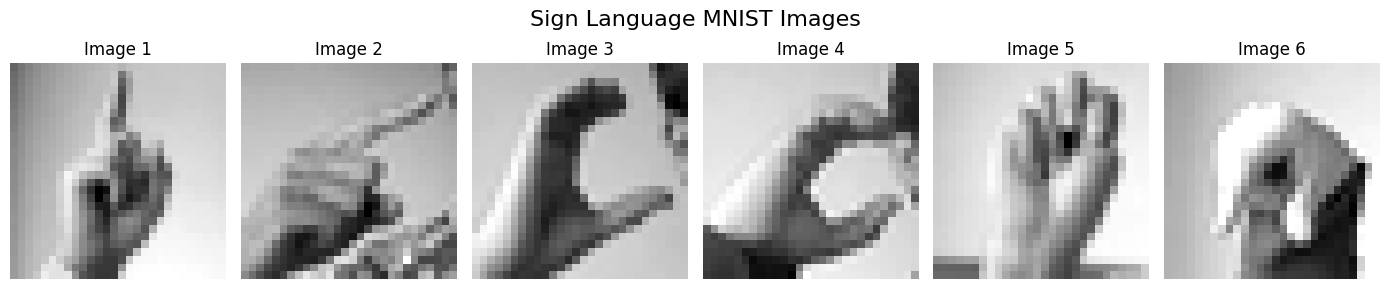

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(14, 3))
fig.suptitle('Sign Language MNIST Images', fontsize=16)

# Plot one image from the first 6 images in X_train
for ii in range(6):
    # X_train is already reshaped to (N, 28, 28, 1) and scaled
    # imshow expects (height, width) or (height, width, channels)
    # We can squeeze the last dimension for grayscale display
    axes[ii].imshow(X_train[ii].squeeze(), cmap='gray')
    # We can't easily determine the letter from the raw pixel data without the label
    # For now, we'll just label them as "Image #"
    axes[ii].set_title(f'Image {ii+1}')
    axes[ii].axis('off') # Hide axes ticks

plt.tight_layout()
plt.show()

In [ ]:
# Convert the image into its numpy array representation
sample_array = tf.keras.preprocessing.image.img_to_array(X_train[ii])

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (28, 28, 1)


In [ ]:
sample_array[0,:5]

array([[0.6313726 ],
       [0.65882355],
       [0.6745098 ],
       [0.6784314 ],
       [0.69803923]], dtype=float32)

In [ ]:
# GRADED FUNCTION: train_val_datasets
def train_val_datasets(X_train, y_train_oh, X_test, y_test_oh):
    """Create train and validation datasets from numpy arrays

    Args:
        X_train (np.ndarray): Training images array.
        y_train_oh (np.ndarray): One-hot encoded training labels array.
        X_test (np.ndarray): Testing images array.
        y_test_oh (np.ndarray): One-hot encoded testing labels array.

    Returns:
        (tf.data.Dataset, tf.data.Dataset): train and validation datasets
    """
    ### START CODE HERE ###
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_oh))
    validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_oh))
    ### END CODE HERE ###

    return train_dataset, validation_dataset

In [ ]:
# Create train and validation datasets
train_dataset, validation_dataset = train_val_datasets(X_train, y_train_oh, X_test, y_test_oh)

# Define batch size and prefetch buffer size
BATCH_SIZE = 32
BUFFER_SIZE = tf.data.AUTOTUNE

# Apply batching and prefetching to the datasets
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(buffer_size=BUFFER_SIZE)

print(f"Images of train dataset have shape: {train_dataset.element_spec[0].shape}")
print(f"Labels of train dataset have shape: {train_dataset.element_spec[1].shape}")
print(f"Images of validation dataset have shape: {validation_dataset.element_spec[0].shape}")
print(f"Labels of validation dataset have shape: {validation_dataset.element_spec[1].shape}")

Images of train dataset have shape: (None, 28, 28, 1)
Labels of train dataset have shape: (None, 26)
Images of validation dataset have shape: (None, 28, 28, 1)
Labels of validation dataset have shape: (None, 26)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),

])

In [ ]:
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= 0.999 and logs.get('val_accuracy') >= 0.95:
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True



CALLBACKS = [EarlyStopping()]

In [ ]:
# GRADED FUNCTION: create_model
def create_model():
    """Create the classifier model

    Returns:
        tf.keras.model.Sequential: CNN for multi-class classification
    """
    ### START CODE HERE ###

    # Define the model
    # Use no more than 2 Conv2D and 2 MaxPooling2D
    model = tf.keras.models.Sequential([
        # Define an input layer
        tf.keras.layers.Input(shape=(28,28,1)), # Set correct input size
        data_augmentation, # Added data augmentation

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(26, activation='softmax')
        ])

    # Changed loss to 'categorical_crossentropy' for one-hot encoded labels
    model.compile(optimizer = 'rmsprop',
                  loss = 'categorical_crossentropy', # Changed loss function
                  metrics = ['accuracy'])

    ### END CODE HERE ###
    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 870,618 (3.32 MB)

 Trainable params: 870,618 (3.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 28, 28, 1)
Output shape: (None, 26)


In [ ]:
for images, labels in train_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 26)


In [ ]:
# Train your model
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=validation_dataset,
                    callbacks = CALLBACKS)

Epoch 1/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.1556 - loss: 2.8102 - val_accuracy: 0.4516 - val_loss: 1.6115
Epoch 2/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 80s 66ms/step - accuracy: 0.5869 - loss: 1.2486 - val_accuracy: 0.6380 - val_loss: 1.0698
Epoch 3/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - accuracy: 0.7795 - loss: 0.6375 - val_accuracy: 0.7228 - val_loss: 0.9106
Epoch 4/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 56s 65ms/step - accuracy: 0.8647 - loss: 0.3946 - val_accuracy: 0.8355 - val_loss: 0.4748
Epoch 5/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 53s 62ms/step - accuracy: 0.9125 - loss: 0.2606 - val_accuracy: 0.9003 - val_loss: 0.3273
Epoch 6/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 56s 65ms/step - accuracy: 0.9333 - loss: 0.1949 - val_accuracy: 0.9296 - val_loss: 0.3014
Epoch 7/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 60s 70ms/step - accuracy: 0.9492 - loss: 0.1521 - val_accuracy: 0.9334 - val_loss: 0.2481
Epoch 8/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 58s 67ms/step - accuracy: 0.9552 - loss: 0.1306 - 

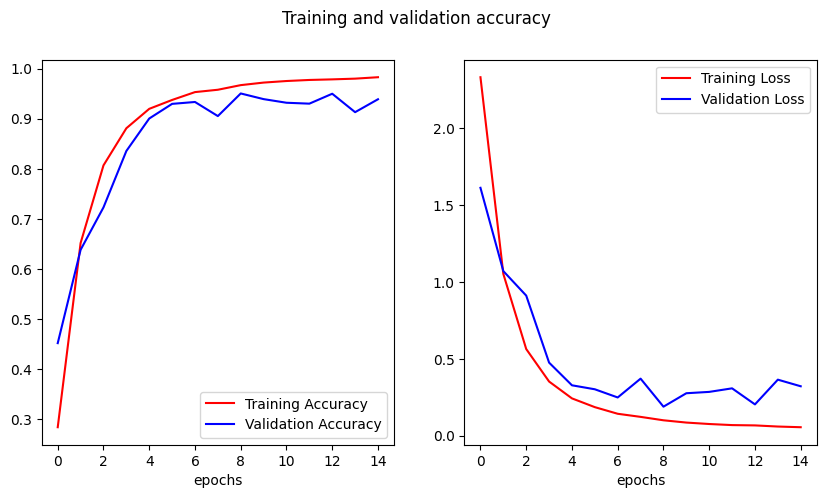

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


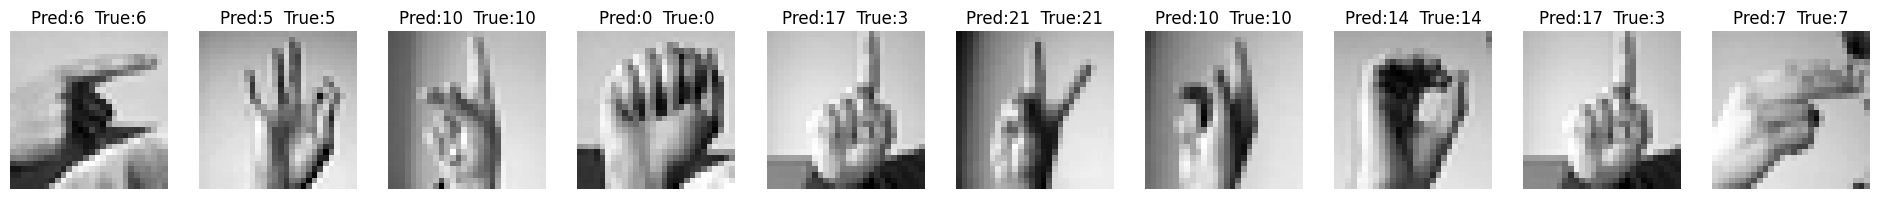

In [ ]:
# lets predict some classes
sample_imgs = X_test[:10]

pred_prob = model.predict(sample_imgs)
y_pred = pred_prob.argmax(axis=1)


# Show side-by-side
fig, ax = plt.subplots(1, 10, figsize=(24, 3))
for i in range(10):
    ax[i].imshow(sample_imgs[i].reshape(28, 28), cmap='gray')
    ax[i].set_title(f'Pred:{y_pred[i]}  True:{y_test[i]}')
    ax[i].axis('off')


plt.show()